#  Problem Statement

- Explore and prepare the data (Tokenization, Stemming, Stopwords, visualization, etc.)
- Build a BOW and train a KNN, Decision Tree, and SVM model
- Evaluate the above models (confusion matrix, accuracy, classification report, etc.)
- Use one of the word embeddings (word2vec, Glove, fasText) and build a CNN model and compare the result   with question 2


# Importing Libraries

- Initially we will import all the libraries which will be used in our assignment

In [1]:
#!pip install tensorflow
import pandas as pd
import numpy as np
import seaborn as sb
import plotly.express as px
import matplotlib.pyplot as plt
import re
import os
import nltk
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets, layers, models, losses
from sklearn.svm import SVC
from wordcloud import WordCloud,STOPWORDS
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords  
from nltk import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')

# Data Exploration and Preparation

In [2]:
# Reading the data
ens_learn = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='cp1252', names = {0 : 'targets', 1 : 'ids', 2 : 'date', 3 : 'flag', 4 : 'user', 5 : 'text'})
ens_learn_copy = ens_learn
# Checking first 5 rows of data
ens_learn.columns=['target', 'ids','date','flag','user','text']
ens_learn.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


- Taking 10 percent of data from our dataset

In [3]:
ens_learn = ens_learn.sample(10000)

- 160k of data with 6 coumns

In [4]:
# Checking number of rows and columns
ens_learn.shape

(10000, 6)

In [5]:
# Names of columns
ens_learn.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [6]:
# complete information of data with datatypes of columns
ens_learn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 988903 to 1308571
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  10000 non-null  int64 
 1   ids     10000 non-null  int64 
 2   date    10000 non-null  object
 3   flag    10000 non-null  object
 4   user    10000 non-null  object
 5   text    10000 non-null  object
dtypes: int64(2), object(4)
memory usage: 546.9+ KB


In [7]:
#Checking number of null values
ens_learn.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

- There are no null values in our dataset

In [8]:
# Checking the initial date of tweets  
ens_learn['date'].min()

'Fri Apr 17 20:31:47 PDT 2009'

In [9]:
# Checking last date of tweets
ens_learn['date'].max()

'Wed May 27 07:27:06 PDT 2009'

In [10]:
# number of duplicates
print(ens_learn.duplicated().loc[lambda x : x == True].count())

0


- There are no duplicates in the dataframe

# Data Cleaning


- Now we are cleaning the data So that our models provide us with better precision and acuracy. I named and define them with what iws happening.

In [11]:

# Removing the URl

def rem_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Removing the stepwords 'english'
def rem_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    return text

# Removing the html  
def rem_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_at_mentions(text):
    return re.sub(r'@\w+', '', text)


# Removing emojis by codes
def rem_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF" 
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Fixing the text
def fixing(text):
    text = re.sub(r"Mr\'s", " he is", text)
    text = re.sub(r"Mr\'.", " he is", text)
    text = re.sub(r"Ms\'.", " She ", text)
    text = re.sub(r"She\'s", " she is", text)
    text = re.sub(r"I\'m", " i am", text)
    text = re.sub(r"haven\'t", " have not", text)
    text = re.sub(r"you\'r", " you are", text)
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    text = re.sub(r" plz", " please", text)
    text = re.sub(r"it\'s", " its", text) 
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"He\'s", " he is", text)
    text = re.sub(r"in\'s", " in", text)
    return text

# Seperate alphabets
def sep_alphabets(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)


def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

ens_learn['final_text'] = ens_learn['text']

ens_learn['final_text'] = ens_learn['final_text'].astype(str).apply(remove_at_mentions)
ens_learn['final_text'] = ens_learn['final_text'].apply(lambda x : rem_url(x))
ens_learn['final_text'] = ens_learn['final_text'].apply(lambda x : rem_stopwords(x))
ens_learn['final_text'] = ens_learn['final_text'].apply(lambda x : rem_html(x))
ens_learn['final_text'] = ens_learn['final_text'].apply(lambda x : rem_emoji(x))
ens_learn['final_text'] = ens_learn['final_text'].apply(lambda x : fixing(x))
ens_learn['final_text'] = ens_learn['final_text'].apply(lambda x : sep_alphabets(x))
ens_learn['final_text'] = ens_learn['final_text'].apply(lambda x : tweet_to_words(x))
ens_learn['final_text'] = ens_learn['final_text'].astype(str).replace("plz", "please", regex=True)

- After cleaning the whole data whoich we take, Now we will see the outcomes in our dataframe. We remove urls, html,emojis,make words proper So the reader and machine can read easily and separate alphabets with spaces

In [12]:
ens_learn['final_text']

988903                         nice see able tweet pen paper
739127     happy fathers day daddys deserve iit urgh stil...
1186996    oh good place like go hoppi hari beautiful fun...
901630            france last friday also coming one working
1083835                            totally recommended sweet
                                 ...                        
1255110                                         omw sox game
215909                   miss every carlos show super bummed
183564             cant even talk joe without getting moaned
1540892                lines vines trying times amazing love
1308571    wow congrats need put something buy even bootl...
Name: final_text, Length: 10000, dtype: object

# Tokenization 

In [13]:
# A function for the tokenization
def tokenize(text):
  return text.split()

  # Apply the tokenization function to the 'text' column
ens_learn['new_tokens'] = ens_learn['final_text'].apply(tokenize)
ens_learn['new_tokens']

988903                  [nice, see, able, tweet, pen, paper]
739127     [happy, fathers, day, daddys, deserve, iit, ur...
1186996    [oh, good, place, like, go, hoppi, hari, beaut...
901630     [france, last, friday, also, coming, one, work...
1083835                        [totally, recommended, sweet]
                                 ...                        
1255110                                     [omw, sox, game]
215909            [miss, every, carlos, show, super, bummed]
183564     [cant, even, talk, joe, without, getting, moaned]
1540892         [lines, vines, trying, times, amazing, love]
1308571    [wow, congrats, need, put, something, buy, eve...
Name: new_tokens, Length: 10000, dtype: object

- Breaking down a larger piece of text into smaller pieces called tokens. These tokens can be individual words, phrases, symbols, or even individual characters. Tokenization allows for more accurate analysis of text data by allowing the model to focus on individual words or phrases rather than the entire document.

# Stemming 

In [14]:

snowbs = SnowballStemmer(language='english')
def stemmer(text):
    text = [snowbs.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text

ens_learn['stemming'] = ens_learn['final_text'].apply(stemmer)
ens_learn['stemming']


988903                          nice see abl tweet pen paper
739127     happi father day daddi deserv iit urgh still l...
1186996    oh good place like go hoppi hari beauti funni ...
901630                  franc last friday also come one work
1083835                                total recommend sweet
                                 ...                        
1255110                                         omw sox game
215909                       miss everi carlo show super bum
183564                   cant even talk joe without get moan
1540892                         line vine tri time amaz love
1308571    wow congrat need put someth buy even bootleg rock
Name: stemming, Length: 10000, dtype: object

- The main purpose of stemming is to reduce the dimensionality of the data by reducing the number of unique words in the text. I have made a separate column named stemming for the results and we can see the final text and the stemmed text below.

In [15]:
ens_learn

,target,ids,date,flag,user,text,final_text,new_tokens,stemming
988903,4,1834812857,Mon May 18 04:17:02 PDT 2009,NO_QUERY,GrahamChastney,@vsmith1 Nice to see you have been able to twe...,nice see able tweet pen paper,"[nice, see, able, tweet, pen, paper]",nice see abl tweet pen paper
739127,0,2265650549,Sun Jun 21 07:02:08 PDT 2009,NO_QUERY,MrSBiiGgaVeLLii,HaPpy FaThErS DaY 2 ALL ThE DaDdYs OuT ThErE T...,happy fathers day daddys deserve iit urgh stil...,"[happy, fathers, day, daddys, deserve, iit, ur...",happi father day daddi deserv iit urgh still l...
1186996,4,1983083184,Sun May 31 12:28:20 PDT 2009,NO_QUERY,jeess_,@dougiemcfly oh that's good ^^ the place I mo...,oh good place like go hoppi hari beautiful fun...,"[oh, good, place, like, go, hoppi, hari, beaut...",oh good place like go hoppi hari beauti funni ...
901630,4,1694273646,Mon May 04 01:52:19 PDT 2009,NO_QUERY,jbfeldis,@dangriffey In France it was last Friday and a...,france last friday also coming one working,"[france, last, friday, also, coming, one, work...",franc last friday also come one work
1083835,4,1968927342,Fri May 29 22:34:00 PDT 2009,NO_QUERY,jeNELLY_n,UP in 3D is totally recommended it was so sweet.,totally recommended sweet,"[totally, recommended, sweet]",total recommend sweet
...,...,...,...,...,...,...,...,...,...
1255110,4,1997217376,Mon Jun 01 16:27:44 PDT 2009,NO_QUERY,Chiggady,Omw to the Sox game,omw sox game,"[omw, sox, game]",omw sox game
215909,0,1975587381,Sat May 30 15:28:29 PDT 2009,NO_QUERY,Rachelskirts,@RobInterrupted: I've had to miss EVERY Carlos...,miss every carlos show super bummed,"[miss, every, carlos, show, super, bummed]",miss everi carlo show super bum
183564,0,1967452989,Fri May 29 19:36:26 PDT 2009,NO_QUERY,ohjester,Cant even talk to joe without getting moaned at,cant even talk joe without getting moaned,"[cant, even, talk, joe, without, getting, moaned]",cant even talk joe without get moan
1540892,4,2180576929,Mon Jun 15 10:39:32 PDT 2009,NO_QUERY,sarahclarke94,lines vines and trying times is amazing... i l...,lines vines trying times amazing love,"[lines, vines, trying, times, amazing, love]",line vine tri time amaz love


# Visualization 

- First we are grouping to get the tweets date wise and then we will visualize the dataframe and see the increasing counts of tweets with the dates

In [16]:
# Counting number of tweets with dates correspondingly 

ens_learn['date'] = pd.to_datetime(ens_learn['date']).dt.date
numberoftweets = ens_learn.groupby('date').size()
numberoftweets=numberoftweets.reset_index()
numberoftweets.columns=['Date', 'Count']
numberoftweets


,Date,Count
0,2009-04-06,22
1,2009-04-07,112
2,2009-04-17,26
3,2009-04-18,162
4,2009-04-19,158
5,2009-04-20,120
6,2009-04-21,49
7,2009-05-01,51
8,2009-05-02,167
9,2009-05-03,238


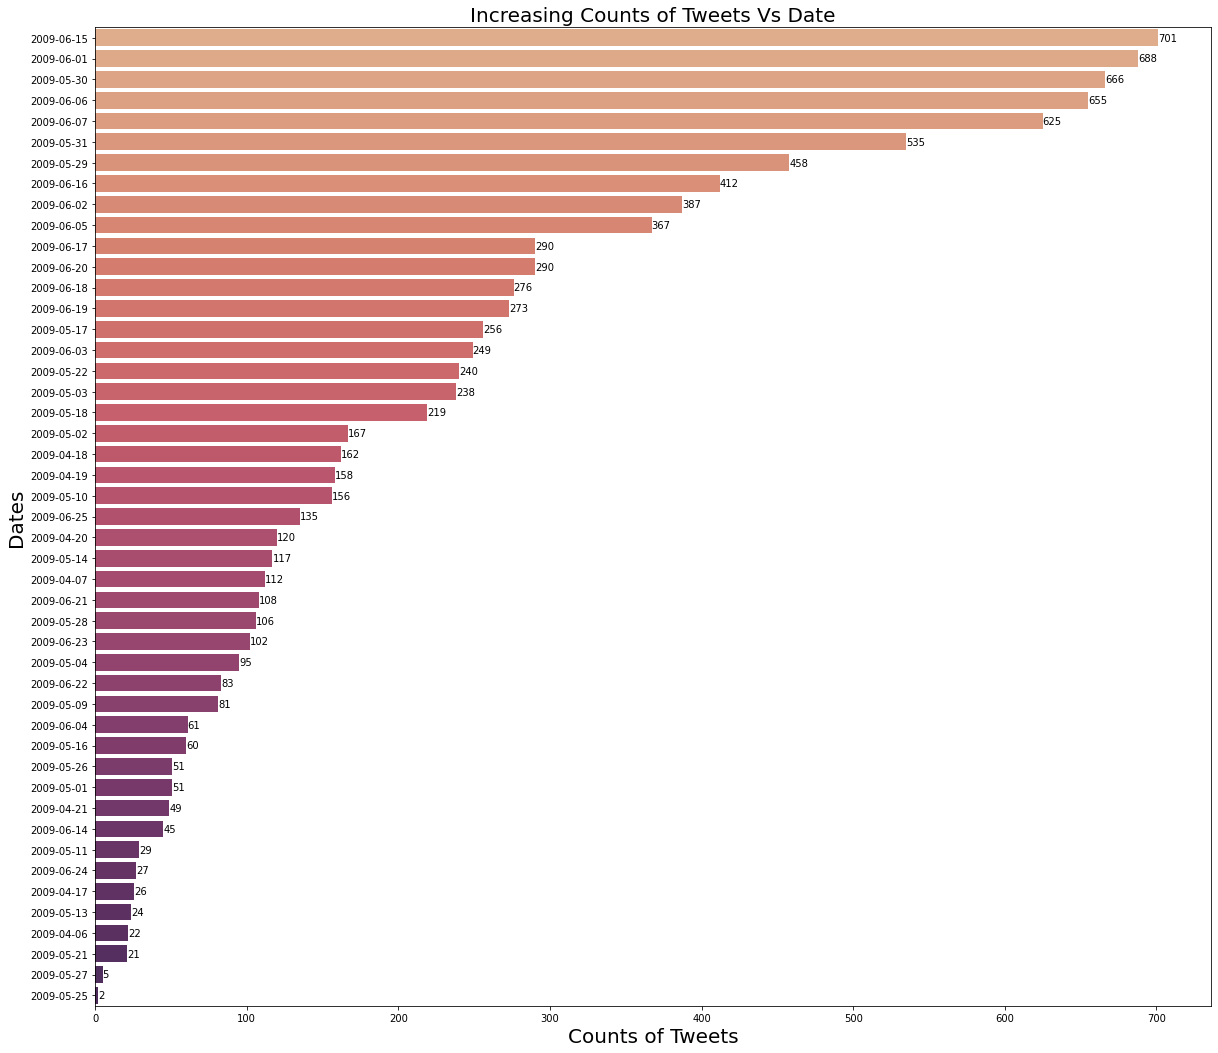

In [17]:
# Plotting the tweets with counts

plt.figure(figsize=(20,18))
show = sb.countplot(data = ens_learn, y = 'date',
                   palette='flare',
                   order = ens_learn.date.value_counts().index)

show.bar_label(show.containers[0])
show.set_title('Increasing Counts of Tweets Vs Date', size = '20')
plt.ylabel("Dates", size = '20')
plt.xlabel("Counts of Tweets", size = '20')
plt.show()

# Question 2

# Bag of Words 

In [18]:
# split the data into training and testing  
train, test = train_test_split(ens_learn, test_size=0.3, random_state=15)

In [19]:
# Build the BOW model using Tokenizer
victor = Tokenizer()
victor.fit_on_texts(train.stemming)

In [20]:
maxcount = ens_learn['stemming'].apply(lambda x: len(x.split())).max()

In [21]:
maxcount

24

- We will apply our modelling on the stemmed data and later on, we will do CNN and then compare the results.

In [22]:
# Training set
my_train = victor.texts_to_sequences(train.stemming)
# Test set
my_test = victor.texts_to_sequences(test.stemming)

In [23]:
X_train = pad_sequences(my_train, maxlen=maxcount, padding="post")
X_test = pad_sequences(my_test, maxlen=maxcount, padding="post")

y_train = train.target.values
y_test = test.target.values

In [24]:
X_train.shape

(7000, 24)

# Data Modelling

In [25]:
# Making KNN Model
KNN = KNeighborsClassifier(n_neighbors=16).fit(X_train, y_train)
print (KNN)

KNeighborsClassifier(n_neighbors=16)


# 1) KNN  

In [26]:
KNN_predictions = KNN.predict(X_test)

## Accuracy 

- Following is the accuracy of our KNN model

In [27]:
# Checking the accuracy
KNN.score(X_test,y_test)

0.5006666666666667

## Classification Report 

In [28]:
print(classification_report(y_test,KNN_predictions))

              precision    recall  f1-score   support

           0       0.50      0.62      0.55      1489
           4       0.51      0.38      0.43      1511

    accuracy                           0.50      3000
   macro avg       0.50      0.50      0.49      3000
weighted avg       0.50      0.50      0.49      3000



## Confusion Matrix 

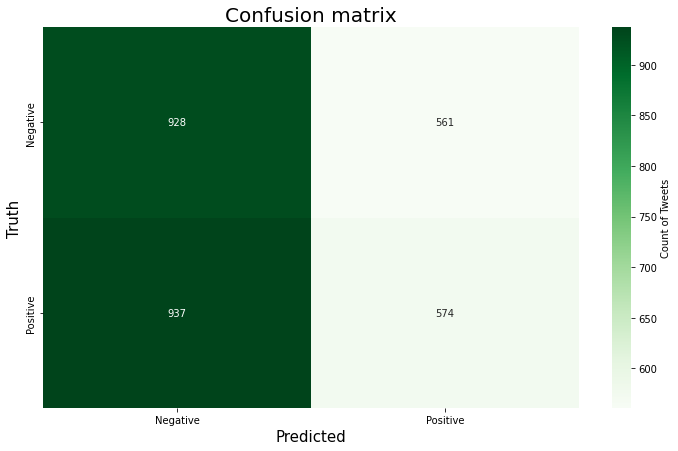

In [29]:
# Confusion Matrix
cm_KNN = confusion_matrix(y_test,KNN_predictions)

# plot confusion matrix 
plt.figure(figsize=(12,7))
sentiment_classes = ['Negative', 'Positive']
sb.heatmap(cm_KNN, cmap=plt.cm.Greens, annot=True,cbar_kws={'label': 'Count of Tweets'},  fmt='d',  
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.title('Confusion matrix', fontsize=20)
plt.show()

- This is the confusion matrix for our KNN Model

# 2)  Decision Tree

In [30]:
# Making Decision Tree Model
Dec_Tree = DecisionTreeClassifier(
    criterion='entropy', max_depth=4).fit(X_train, y_train)

In [31]:
Dec_Tree_predictions = Dec_Tree.predict(X_test)

## Accuracy 

- Below is the accuracy for our Decision Tree Model

In [32]:
# Checking the accuracy
Dec_Tree.score(X_test,y_test)

0.5136666666666667

## Classification Report 

In [33]:
print(classification_report(y_test,Dec_Tree_predictions))

              precision    recall  f1-score   support

           0       0.51      0.70      0.59      1489
           4       0.53      0.33      0.41      1511

    accuracy                           0.51      3000
   macro avg       0.52      0.52      0.50      3000
weighted avg       0.52      0.51      0.50      3000



## Confusion Matrix 

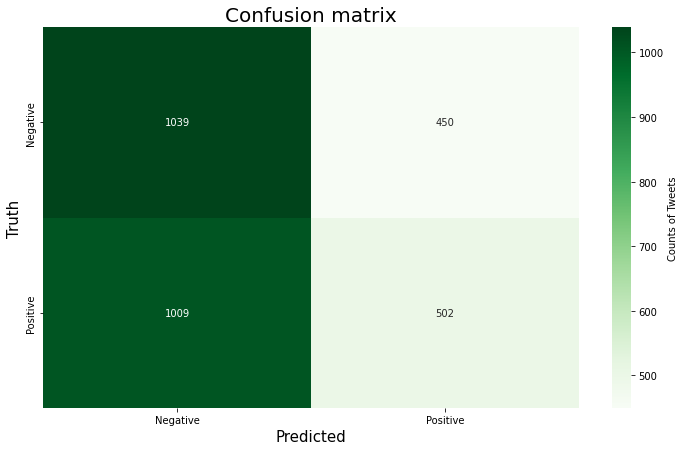

In [34]:
# Confusion Matrix
cm_Dec_Tree = confusion_matrix(y_test,Dec_Tree_predictions)

# plot confusion matrix 
plt.figure(figsize=(12,7))
sentiment_classes = ['Negative', 'Positive']
sb.heatmap(cm_Dec_Tree, cmap=plt.cm.Greens, annot=True,cbar_kws={'label': 'Counts of Tweets'},  fmt='d',  
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.title('Confusion matrix', fontsize=20)
plt.show()

- This is the confusion matrix for our Decision Tree Model

# 3) SVM 

In [35]:
# Building the SVM Model
SVM = svm.SVC(kernel='rbf').fit(X_train, (y_train))

In [36]:
SVM_predictions = SVM.predict(X_test)

## Accuracy 

- Following is the accuracy of our SVM Model. SVM models takes the longest time among all for the training and the outcomes.

In [37]:
SVM.score(X_test,y_test)

0.5146666666666667

## Classification Report 

In [38]:
print(classification_report(y_test,SVM_predictions))

              precision    recall  f1-score   support

           0       0.51      0.85      0.63      1489
           4       0.55      0.19      0.28      1511

    accuracy                           0.51      3000
   macro avg       0.53      0.52      0.46      3000
weighted avg       0.53      0.51      0.46      3000



## Confusion Matrix

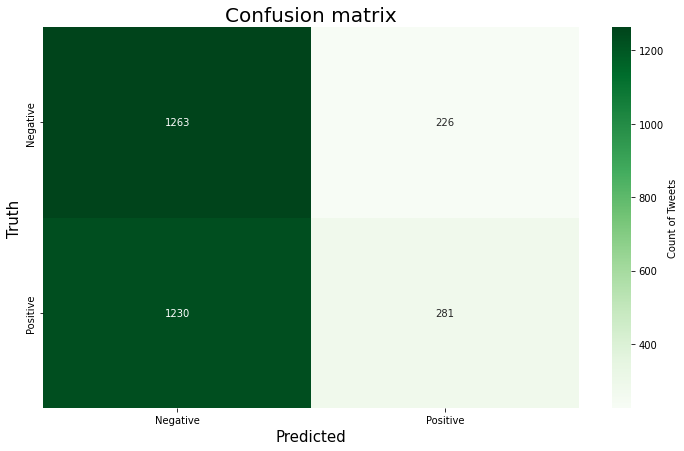

In [39]:
cm_svm = confusion_matrix(y_test,SVM_predictions)

# plot confusion matrix 
plt.figure(figsize=(12,7))
sentiment_classes = ['Negative', 'Positive']
sb.heatmap(cm_svm, cmap=plt.cm.Greens, annot=True,cbar_kws={'label': 'Count of Tweets'},  fmt='d',  
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.title('Confusion matrix', fontsize=20)
plt.show()

# Word2Vec 

- Now we will use Word2Vec and then make the CNN model

In [40]:
from gensim.models import Word2Vec

In [41]:
texts_w2v = ens_learn.stemming.apply(tokenize).to_list()

w2v = Word2Vec(sentences = texts_w2v, window = 3,
               vector_size = X_train.shape[1], min_count = 5, workers = 4, sg = 1)

In [42]:
w2v

- Now we would decode our 0 as Ngative tweets, 2 as neutral and 4 as the positive ones and store them in the decode_sentiment function

In [43]:
decode = {0: "Negative", 2: "Neutral", 4: "Positive"}
def decode_sentiments(label):
    return decode[int(label)]

In [44]:
train.target.apply(lambda x: decode_sentiments(x))

883622     Positive
1515781    Positive
591606     Negative
437915     Negative
658638     Negative
             ...   
318326     Negative
459683     Negative
1590800    Positive
1214032    Positive
912756     Positive
Name: target, Length: 7000, dtype: object

In [45]:
labels = train.target.unique().tolist()
labels.append('Neutral')

- First, a LabelEncoder object is created and fit on the target column of the train data. This is a preprocessing step that converts the labels in the target column into integer values. For example, if the target column contains the labels 'cat', 'dog', and 'bird', the LabelEncoder will convert these labels into the integers 0, 1, and 2, respectively.

- Next, the LabelEncoder is fit on the target column of the test data. This allows the encoder to learn the mapping between the labels and integer values for the test data as well.

- Then, the transform method is used to apply the label encoding to the target columns of both the train and test data. The resulting integer arrays are stored in the variables y_train and y_test, respectively.

- Finally, the reshape method is used to reshape the y_train and y_test arrays into a column vector shape with a single column and as many rows as needed. The -1 value for the number of rows tells NumPy to infer the number of rows based on the length of the data and the number of columns.

In [46]:

encode = LabelEncoder()
encode.fit(train.target.tolist())
encode.fit(test.target.tolist())

y_train = encode.transform(train.target.tolist())
y_test = encode.transform(test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (7000, 1)
y_test (3000, 1)


- After below code has been run, the embed array should contain the embedding vectors for the words in the vocabulary, with one row per word and one column per feature in the embedding space. The embed array can then be used as input to a machine learning model to capture the semantic meaning of the words in a text.

In [47]:
max_length = len(victor.word_index)+1
embed = np.zeros((max_length, X_train.shape[1]))
for word, i in victor.word_index.items():
  if word in w2v.wv:
    embed[i] = w2v.wv[word]
print(embed.shape)

(8474, 24)


# CNN Model 

In [48]:
cnn= models.Sequential()
cnn.add(Embedding(max_length, X_train.shape[1], 
                        weights= [embed], input_length= X_train.shape[1], trainable= False))
cnn.add(Dropout(0.5))
cnn.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
cnn.add(Dense(1, activation='sigmoid'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 24, 24)            203376    
_________________________________________________________________
dropout (Dropout)            (None, 24, 24)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               50000     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 253,477
Trainable params: 50,101
Non-trainable params: 203,376
_________________________________________________________________


In [49]:
cnn.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [50]:
remember = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [51]:
results = cnn.fit(X_train, y_train, batch_size=X_train.shape[1], epochs=15, validation_split=0.1, verbose=1)

Epoch 1/15
263/263 [==============================] - 21s 66ms/step - loss: 0.6929 - accuracy: 0.5089 - val_loss: 0.6942 - val_accuracy: 0.4771
Epoch 2/15
263/263 [==============================] - 17s 66ms/step - loss: 0.6920 - accuracy: 0.5256 - val_loss: 0.7256 - val_accuracy: 0.5257
Epoch 3/15
263/263 [==============================] - 17s 66ms/step - loss: 0.6915 - accuracy: 0.5302 - val_loss: 0.6906 - val_accuracy: 0.5400
Epoch 4/15
263/263 [==============================] - 17s 65ms/step - loss: 0.6849 - accuracy: 0.5489 - val_loss: 0.6844 - val_accuracy: 0.5571
Epoch 5/15
263/263 [==============================] - 17s 66ms/step - loss: 0.6855 - accuracy: 0.5543 - val_loss: 0.6794 - val_accuracy: 0.5786
Epoch 6/15
263/263 [==============================] - 17s 65ms/step - loss: 0.6836 - accuracy: 0.5570 - val_loss: 0.6729 - val_accuracy: 0.5814
Epoch 7/15
263/263 [==============================] - 18s 67ms/step - loss: 0.6842 - accuracy: 0.5573 - val_loss: 0.6644 - val_accuracy:

In [52]:
cnn_pred = cnn.predict(X_test)
cnn_pred = np.where(cnn_pred < 0.5, 0, 1)

# Accuracy 

- Below is the accuracy for the CNN Matix

In [53]:
cnn.evaluate(X_test,y_test)

94/94 [==============================] - 2s 16ms/step - loss: 0.6933 - accuracy: 0.5350


[0.6932976245880127, 0.5350000262260437]

# Classification Matrix 

In [54]:
print(classification_report(y_test,cnn_pred))

              precision    recall  f1-score   support

           0       0.52      0.88      0.65      1489
           1       0.63      0.19      0.29      1511

    accuracy                           0.54      3000
   macro avg       0.57      0.54      0.47      3000
weighted avg       0.57      0.54      0.47      3000



# Confusion Matrix 

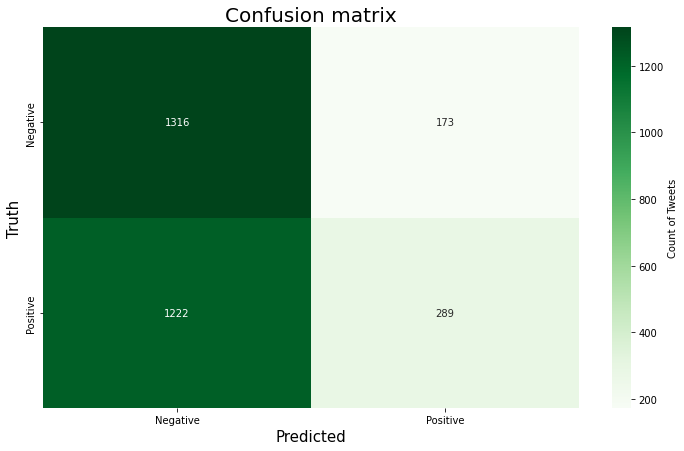

In [55]:
cm_cnn = confusion_matrix(y_test,cnn_pred)

# plot confusion matrix 
plt.figure(figsize=(12,7))
sentiment_classes = ['Negative', 'Positive']
sb.heatmap(cm_cnn, cmap=plt.cm.Greens, annot=True,cbar_kws={'label': 'Count of Tweets'},  fmt='d',  
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.title('Confusion matrix', fontsize=20)
plt.show()

# Results 

In [56]:
df_results = pd.DataFrame()
df_results['Algorithm'] = [
    'KNN', 'Decision Tree', 'SVM', 'CNN']
df_results['Score'] = [accuracy_score(KNN_predictions,y_test), accuracy_score(Dec_Tree_predictions,y_test),accuracy_score(SVM_predictions,y_test),accuracy_score(cnn_pred,y_test) ]
df_results.columns = ['Algorithm','Score']
df_results

,Algorithm,Score
0,KNN,0.309333
1,Decision Tree,0.346333
2,SVM,0.421000
3,CNN,0.535000


- As we can see that the accuracy of CNN is giving us the best accuracy from our dataframe among the first three. But when we compare the upper three models with CNN then CNN is giving us the best accuracy among all as shown.

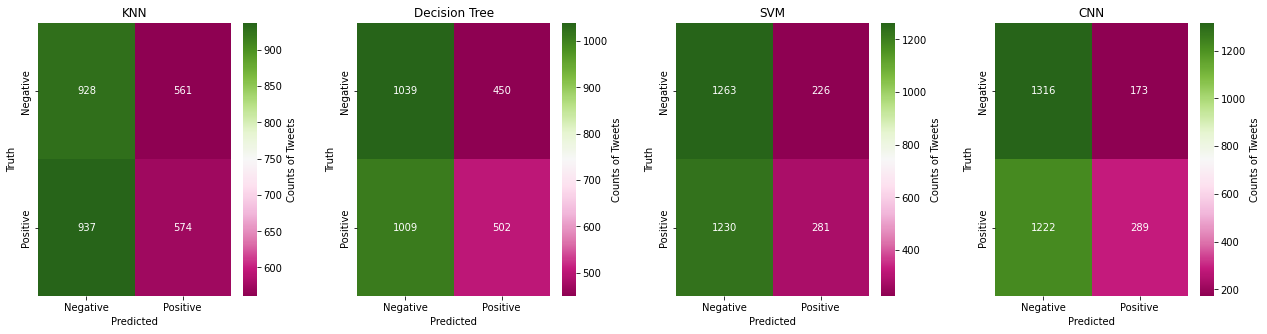

In [57]:
df_cm = pd.DataFrame()
df_cm['Name'] = ['KNN','Decision Tree','SVM','CNN']
df_cm['CM'] = [cm_KNN,cm_Dec_Tree,cm_svm,cm_cnn]
df_cm.columns = ['Name','CM']
df_cm = df_cm.transpose()

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(18, 5))
ax = ax.flatten()
sentiment_classes = ['Negative', 'Positive']
index=0
for i in df_cm.columns:
    sb.heatmap(df_cm[i][1], annot=True, ax=ax[index],cbar_kws={'label': 'Counts of Tweets'}, fmt='d',  
            xticklabels=sentiment_classes , yticklabels=sentiment_classes ,cmap="PiYG")
    ax[index].set_title(df_cm[i][0])
    ax[index].set_xlabel('Predicted')
    ax[index].set_ylabel('Truth')
    index += 1
plt.tight_layout(pad=2)
plt.show()

- If we see the balanced data among all the trained models then CNN is the best. There is a difference among all but CNN is having the least difference among these 3. The accuracy and the confusion matrix shows that CNN is most efficient